In [3]:
import json
import os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')

/Users/erg1/miniforge3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [61]:
two_pipe_fps = os.listdir('two-pipes')
four_pipe_fps = os.listdir('four-pipes')
eight_pipe_fps = os.listdir('eight-pipes')

In [62]:
def calc_total_times(fps, source_dir):
    epoch_total_times, allreduce_total_times, randomk_total_times, backward_total_times, forward_total_times = [], [], [], [], []
    compression_types, compression_metrics = [], []
    for i, fp in enumerate(fps):
        compression_types.append(fp.split('_')[2])
        compression_metrics.append(fp.split('_')[3])
        with open(os.path.join(source_dir, fp)) as f:
            data = json.load(f)
        
        epoch_total_times.append(sum([data[f"trainloop_epoch{i}_rank0"]['total_time'] for i in range(data['train_params']['epochs'])]))
        
        if compression_types[i] == 'randomk':
            compression_types[i] += f" (k = {compression_metrics[i]})"
            allreduce_total_times.append(data['randomk.all_reduce']['total_time'])
        elif compression_types[i] == 'powersgd':
            allreduce_total_times.append(data['powersgd.uncompressed.all_reduce']['total_time'] + data['powersgd.Ps.all_reduce']['total_time'] + data['powersgd.Qs.all_reduce']['total_time'])
        else:
            allreduce_total_times.append(data['pytorch.all_reduce']['total_time'])
        
        backward_total_times.append(sum([data[f"backward_epoch{i}_rank0"]['total_time'] for i in range(data['train_params']['epochs'])]))
        forward_total_times.append(sum([data[f"forward_epoch{i}_rank0"]['total_time'] for i in range(data['train_params']['epochs'])]))
    
    return pd.DataFrame({'compression_type': compression_types, 'epoch_total_time': epoch_total_times, 'allreduce_total_time': allreduce_total_times, 'backward_total_time': backward_total_times, 'forward_total_time': forward_total_times}) 

In [63]:
def calc_avg_times(fps, source_dir):
    epoch_avg_times, allreduce_avg_times, randomk_avg_times, backward_avg_times, forward_avg_times = [], [], [], [], []
    compression_types, compression_metrics = [], []
    for i, fp in enumerate(fps):
        compression_types.append(fp.split('_')[2])
        compression_metrics.append(fp.split('_')[3])
        with open(os.path.join(source_dir, fp)) as f:
            data = json.load(f)
            
        epoch_avg_times.append(np.mean([data[f"trainloop_epoch{i}_rank0"]['average_duration'] for i in range(data['train_params']['epochs'])]))
        
        if compression_types[i] == 'randomk':
            compression_types[i] += f" (k = {compression_metrics[i]})"
            allreduce_avg_times.append(data['randomk.all_reduce']['average_duration'])
        elif compression_types[i] == 'powersgd':
            allreduce_avg_times.append(data['powersgd.uncompressed.all_reduce']['average_duration'] + data['powersgd.Ps.all_reduce']['average_duration'] + data['powersgd.Qs.all_reduce']['average_duration'])
        else:
            allreduce_avg_times.append(data['pytorch.all_reduce']['average_duration'])
        
        backward_avg_times.append(np.mean([data[f"backward_epoch{i}_rank0"]['average_duration'] for i in range(data['train_params']['epochs'])]))
        forward_avg_times.append(np.mean([data[f"forward_epoch{i}_rank0"]['average_duration'] for i in range(data['train_params']['epochs'])]))
        
    return pd.DataFrame({'compression_type': compression_types, 'epoch_avg_time': epoch_avg_times, 'allreduce_avg_time': allreduce_avg_times, 'backward_avg_time': backward_avg_times, 'forward_avg_time': forward_avg_times} )

In [64]:
two_pipes_results = calc_total_times(two_pipe_fps, 'two-pipes').merge(calc_avg_times(two_pipe_fps, 'two-pipes'), on = 'compression_type')
two_pipes_results['n_pipelines'] = 2

four_pipes_results = calc_total_times(four_pipe_fps, 'four-pipes').merge(calc_avg_times(four_pipe_fps, 'four-pipes'), on = 'compression_type')
four_pipes_results['n_pipelines'] = 4

eight_pipes_results = calc_total_times(eight_pipe_fps, 'eight-pipes').merge(calc_avg_times(eight_pipe_fps, 'eight-pipes'), on = 'compression_type')
eight_pipes_results['n_pipelines'] = 8

In [65]:
result_df = pd.concat([two_pipes_results, four_pipes_results, eight_pipes_results])
result_df['epoch_throughput'] = 50_000 / result_df['epoch_avg_time'] 
result_df.sort_values(['n_pipelines', 'compression_type'])

,compression_type,epoch_total_time,allreduce_total_time,backward_total_time,forward_total_time,epoch_avg_time,allreduce_avg_time,backward_avg_time,forward_avg_time,n_pipelines,epoch_throughput
0,None,264.560359,121.556118,208.569294,19.286355,26.456036,0.024340,0.417139,0.038573,2,1889.927886
2,powersgd,178.223404,6.902426,115.210084,19.052167,17.822340,0.001534,0.230420,0.038104,2,2805.467675
1,randomk (k = 0.3),224.029982,40.058834,169.321885,19.288580,22.402998,0.008021,0.338644,0.038577,2,2231.844130
4,randomk (k = 0.5),277.635168,64.342538,222.221156,19.376192,27.763517,0.012884,0.444442,0.038752,2,1800.924586
3,randomk (k = 0.8),375.831784,119.738114,319.051941,19.546862,37.583178,0.023976,0.638104,0.039094,2,1330.382424
4,None,283.436449,167.026090,238.555191,18.974945,28.343645,0.033445,0.477110,0.037950,4,1764.063871
3,powersgd,152.881411,7.088294,98.164860,18.733665,15.288141,0.001575,0.196330,0.037467,4,3270.508808
2,randomk (k = 0.3),208.512452,52.253785,166.127872,18.899518,20.851245,0.010463,0.332256,0.037799,4,2397.938324
0,randomk (k = 0.5),268.188231,84.814231,225.147292,18.813677,26.818823,0.016983,0.450295,0.037627,4,1864.362200
1,randomk (k = 0.8),360.215995,135.926832,315.500184,19.088304,36.021599,0.027218,0.631000,0.038177,4,1388.056075


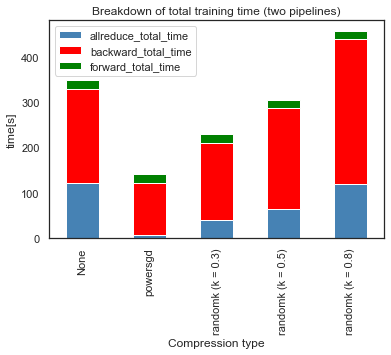

In [66]:
ax = result_df.loc[result_df.n_pipelines==2 ,['compression_type', 'allreduce_total_time', 'backward_total_time', 'forward_total_time']].set_index('compression_type').sort_index().plot(kind='bar', stacked=True, color=['steelblue', 'red', 'green'])
ax.set_xlabel('Compression type')
ax.set_ylabel('time[s]')
plt.title('Breakdown of total training time (two pipelines)')
plt.show()

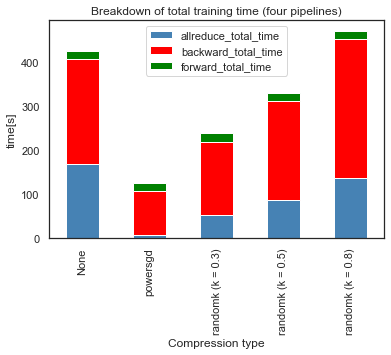

In [67]:
ax = result_df.loc[result_df.n_pipelines==4 ,['compression_type', 'allreduce_total_time', 'backward_total_time', 'forward_total_time']].set_index('compression_type').sort_index().plot(kind='bar', stacked=True, color=['steelblue', 'red', 'green'])
ax.set_xlabel('Compression type')
ax.set_ylabel('time[s]')
plt.title('Breakdown of total training time (four pipelines)')
plt.show()

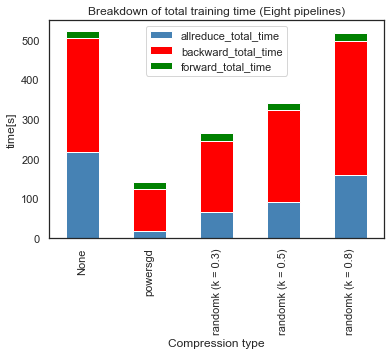

In [68]:
ax = result_df.loc[result_df.n_pipelines==8 ,['compression_type', 'allreduce_total_time', 'backward_total_time', 'forward_total_time']].set_index('compression_type').sort_index().plot(kind='bar', stacked=True, color=['steelblue', 'red', 'green'])
ax.set_xlabel('Compression type')
ax.set_ylabel('time[s]')
plt.title('Breakdown of total training time (Eight pipelines)')
plt.show()

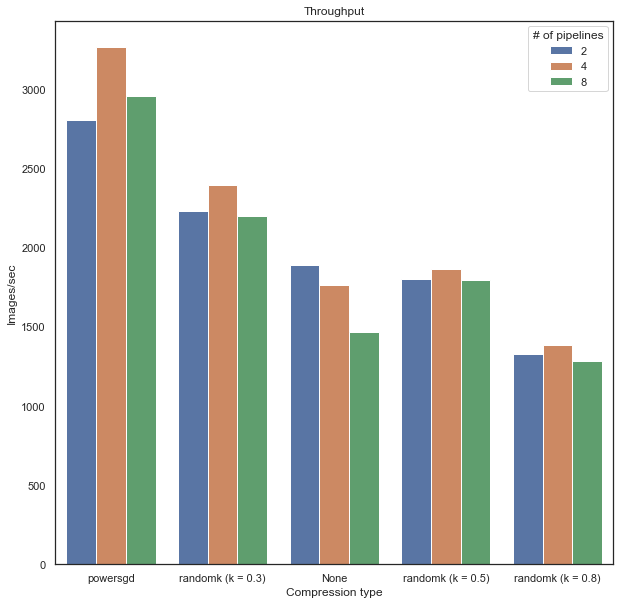

In [69]:
fig, ax = plt.subplots(1, figsize = (10,10))

sns.barplot(x='compression_type', y='epoch_throughput', hue='n_pipelines', data = result_df.sort_values('epoch_throughput', ascending=False), ax=ax)
ax.legend(loc='upper right', title= '# of pipelines')
ax.set_xlabel('Compression type')
ax.set_ylabel('Images/sec')
plt.title('Throughput')
plt.show()

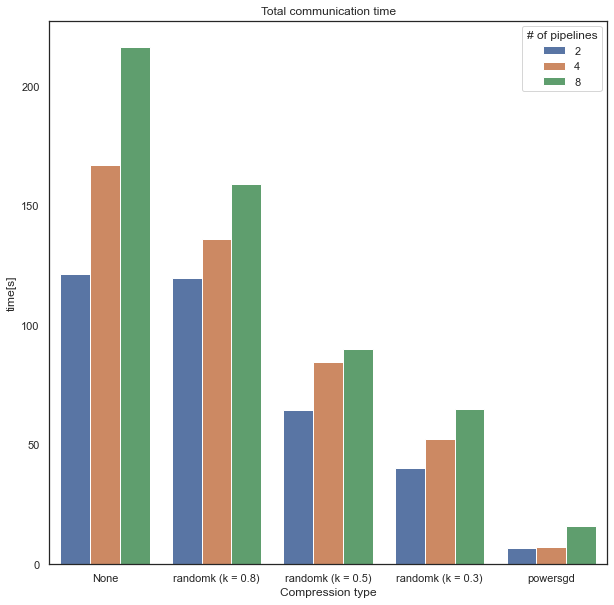

In [70]:
fig, ax = plt.subplots(1, figsize = (10,10))

sns.barplot(x='compression_type', y='allreduce_total_time', hue='n_pipelines', data = result_df.sort_values('allreduce_total_time', ascending=False), ax=ax)
ax.legend(loc='upper right', title= '# of pipelines')
ax.set_xlabel('Compression type')
ax.set_ylabel('time[s]')
plt.title('Total communication time')
plt.show()

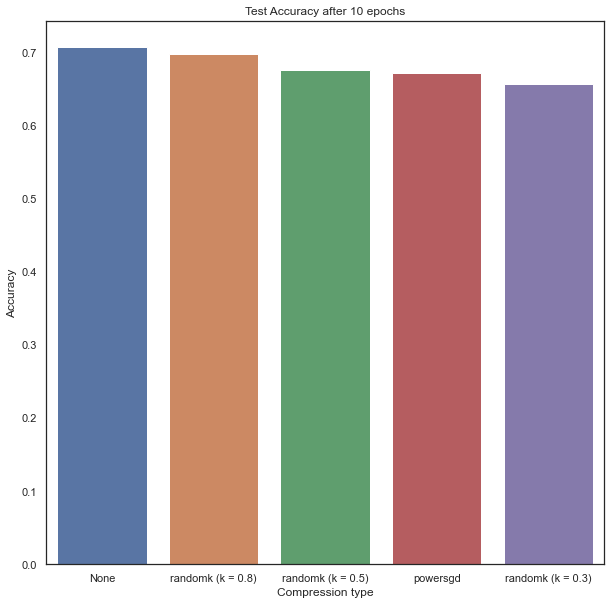

In [71]:
val_accuracy = [0.7075, 0.656, 0.676, 0.6975, 0.671]
comp_type = ['None', 'randomk (k = 0.3)', 'randomk (k = 0.5)', 'randomk (k = 0.8)', 'powersgd']
model_perf = pd.DataFrame({'Accuracy': val_accuracy, 'Compression type': comp_type})

fig, ax = plt.subplots(1, figsize = (10,10))
sns.barplot(x='Compression type', y='Accuracy', data=model_perf.sort_values('Accuracy', ascending=False), ax=ax)
plt.title('Test Accuracy after 10 epochs')
plt.show()